In [ ]:
import math
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun Apr 21 18:42:41 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0              50W / 400W |   5627MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 89.6 gigabytes of available RAM

You are using a high-RAM runtime!


#Рівняння Бюргерса. Точний розв'язок

$\displaystyle \frac{\partial u}{\partial t} + u\frac{\partial u}{\partial x} = \nu \frac{\partial^2 u}{\partial x^2}$

Тестова задача. Домен [0,2], нульові граничні умови, початкова умова визначається з точного розв'язку [Arora, Geeta, Mishra, Shubham, Emaifar, Homan, Khademi, Masoumeh (2023) Numerical Simulation and Dynamics of Burgers’ Equation Using the Modified Cubic B-Spline Differential Quadrature Method. Discrete Dynamics in Nature and Society Volume 2023, Article ID 5102374, 8 pages
https://doi.org/10.1155/2023/5102374
]:

$\displaystyle u(x,t) =  2 \pi \nu \frac{\sin(\gamma)e^\beta+4\sin(2\gamma)e^{-4\beta}}{4+\cos(\gamma)e^\beta+2\cos(2\gamma)e^{-4\beta}},$

де $\gamma=\pi x$, $\beta=-\pi^2 \nu^2 t$

In [ ]:
# x_max = 1
# t_max = 4

#Розв'язок засобами PINN

In [ ]:
class NN(nn.Module):
    def __init__(self):
        super(NN, self).__init__()
        self.net = torch.nn.Sequential(
            nn.Linear(2,64),
            nn.Tanh(),
            nn.Linear(64,64),
            nn.Tanh(),
            nn.Linear(64,64),

            # nn.Tanh(),
            # nn.Linear(20,20),

            nn.Sigmoid(),
            nn.Linear(64,1)
        )
        self.double()
    def forward(self, x):
        out = self.net(x)
        return out

In [ ]:
'''
x_test = torch.arange(-1,1+0.1, 0.1)
#print(x_test)
t_test = torch.arange(0,1+0.1, 0.1)
#print(t_test)

X = torch.stack(torch.meshgrid(x_test,t_test)).reshape(2,-1).T
#print(X)

bc1_test = torch.stack(torch.meshgrid(x_test[-1],t_test)).reshape(2,-1).T
#print(bc1_test)
#print(torch.meshgrid(x_test,t_test))

y_train_test = torch.tensor([1,2,3,4])
print(y_train_test)
y_train_test = y_train_test.unsqueeze(1)
print(y_train_test)
'''

'\nx_test = torch.arange(-1,1+0.1, 0.1)\n#print(x_test)\nt_test = torch.arange(0,1+0.1, 0.1)\n#print(t_test)\n\nX = torch.stack(torch.meshgrid(x_test,t_test)).reshape(2,-1).T\n#print(X)\n\nbc1_test = torch.stack(torch.meshgrid(x_test[-1],t_test)).reshape(2,-1).T\n#print(bc1_test)\n#print(torch.meshgrid(x_test,t_test))\n\ny_train_test = torch.tensor([1,2,3,4])\nprint(y_train_test)\ny_train_test = y_train_test.unsqueeze(1)\nprint(y_train_test)\n'

In [ ]:
# h = 0.01
# k = 0.01
# nu = 0.005
# # nu = 0.5

# x = torch.arange(0,1.2+h, h)
# t = torch.arange(0,5+k, k)

# bc1 = torch.stack(torch.meshgrid(x[0],t)).reshape(2,-1).T
# bc2 = torch.stack(torch.meshgrid(x[-1],t)).reshape(2,-1).T
# ic  = torch.stack(torch.meshgrid(x,t[0])).reshape(2,-1).T

# y_ic  = ic[:,0] / (1 + torch.exp((ic[:,0]**2 - 0.25)/(4*nu)))
# y_ic**2

In [ ]:
class Net:
    def __init__(self):
        device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

        self.model = NN().to(device)

        self.x_max = 8
        self.t_max = 5

        # comp. domain
        self.h = 0.01
        self.k = 0.01
        self.nu = 0.5
        self.epoch = 10000

        x = torch.arange(0, self.x_max + self.h, self.h)
        t = torch.arange(1, self.t_max + self.k, self.k)

        x = x.double()
        t = t.double()

        self.X = torch.stack(torch.meshgrid(x,t)).reshape(2,-1).T
        self.X = self.X.double()
        # print('self.X ', self.X.shape)
        # breakpoint()



        # train data
        bc1 = torch.stack(torch.meshgrid(x[0],t)).reshape(2,-1).T
        bc2 = torch.stack(torch.meshgrid(x[-1],t)).reshape(2,-1).T
        ic  = torch.stack(torch.meshgrid(x,t[0])).reshape(2,-1).T
        # ic2  = torch.stack(torch.meshgrid(x,t[-1])).reshape(2,-1).T
        # print('bc1, ', bc1.shape)
        # print('bc2, ', bc2.shape)
        # print('ic, ', ic.shape)
        # breakpoint()

        bc1 = bc1.double()
        bc2 = bc2.double()
        ic  = ic.double()


        self.X_train = torch.cat([bc1, bc2, ic])

        # print('self.X_train ', self.X_train.shape)
        # breakpoint()

        y_bc1 = torch.zeros(len(bc1))
        y_bc2 = torch.zeros(len(bc2))

        y_ic  = ic[:,0] / (1 + torch.exp((ic[:,0]**2 - 0.25)/(4*self.nu)))

        y_bc1 = y_bc1.double()
        y_bc2 = y_bc2.double()
        y_ic  = y_ic.double()


        self.y_train = torch.cat([y_bc1, y_bc2, y_ic])


        self.y_train = self.y_train.unsqueeze(1)



        self.X = self.X.to(device)
        self.y_train = self.y_train.to(device)
        self.X_train = self.X_train.to(device)
        self.X.requires_grad = True

        # optimizer setting
        self.adam =  torch.optim.Adam(self.model.parameters(), lr=1e-3)
        # self.adam = torch.optim.SGD(self.model.parameters(), lr=1e-3)
        # self.adam = torch.optim.Adamax(self.model.parameters(), lr=1e-3)
        # self.adam = torch.optim.NAdam(self.model.parameters(), lr=1e-3)
        # self.adam = torch.optim.RMSprop(self.model.parameters(), lr=1e-4)

        #Limited-memory Broyden-Fletcher-Goldfarb-Shanno (L-BFGS)
        self.optimizer = torch.optim.LBFGS(
            self.model.parameters(),
            lr=0.01,
            max_iter = 4000,
            max_eval = 4000,
            history_size = 50,
            tolerance_grad = 1e-20,
            tolerance_change = 1.0* np.finfo(float).eps,
            line_search_fn ="strong_wolfe"
        )

        self.criterion = torch.nn.MSELoss()
        # self.criterion = torch.nn.L1Loss()
        self.iter = 1

    def loss_func(self):
        self.adam.zero_grad()
        self.optimizer.zero_grad()

        y_pred = self.model(self.X_train)

        # print('y_pred ', y_pred.shape)
        # print('self.y_train.shape ', self.y_train.shape)
        # breakpoint()


        loss_data = self.criterion(y_pred - self.y_train, torch.zeros_like(self.y_train))

        u = self.model(self.X)

        du_dX = torch.autograd.grad(
            u,
            self.X,
            grad_outputs = torch.ones_like(u),
            create_graph = True,
            retain_graph = True
        )[0]

        #print(du_dX)
        #print("xxxxxxxxxxxxxxxxxxxxxxxxx")
        #print(du_dX[0])

        du_dt = du_dX[:,1]
        du_dx = du_dX[:,0]

        # print('du_dx ', du_dx.shape)
        # print('du_dt ', du_dt.shape)
        # breakpoint()


        du_dXX = torch.autograd.grad(
            du_dX,
            self.X,
            grad_outputs = torch.ones_like(du_dX),
            create_graph = True,
            retain_graph = True
        )[0]

        du_dxx = du_dXX[:,0]

        loss_pde = self.criterion(du_dt + u.squeeze()*du_dx - self.nu * du_dxx, torch.zeros_like(du_dxx))

        loss = loss_pde + loss_data
        loss.backward()

        if self.iter % 100 == 0:
            print(self.iter, loss.item())
            print(loss_pde.item())
            print(loss_data.item())
        self.iter = self.iter+1

        return loss

    def train(self):
        self.model.train()
        for i in range(self.epoch):
            self.adam.step(self.loss_func)
        self.optimizer.step(self.loss_func)

    def eval_(self):
        self.model.eval()

In [ ]:
# training
net = Net()
net.train()

100 0.00520950116992441
0.00032672683177012256
0.004882774338154287
200 0.0024908401695597515
0.0001263937404727304
0.002364446429087021
300 0.0008382135161838426
0.00014536314583093687
0.0006928503703529057
400 0.00030744312877786377
0.00010914073188161777
0.000198302396896246
500 0.00015959788932892423
6.745895691392377e-05
9.213893241500047e-05
600 0.00010254150999716025
4.5194593615118054e-05
5.734691638204219e-05
700 7.319018359146616e-05
3.097902196397837e-05
4.221116162748779e-05
800 5.624685694990216e-05
2.184318076182646e-05
3.44036761880757e-05
900 4.578735533324082e-05
1.6158000248996136e-05
2.962935508424468e-05
1000 3.886211412475275e-05
1.2684230896517278e-05
2.6177883228235473e-05
1100 3.38793560241489e-05
1.0531384275061924e-05
2.3347971749086975e-05
1200 2.9987710948352946e-05
9.109221436809161e-06
2.0878489511543783e-05
1300 2.675403345338967e-05
8.079560265515334e-06
1.8674473187874335e-05
1400 2.3966953102243105e-05
7.2702190972539985e-06
1.6696734004989107e-05
1500

In [ ]:
net.model.eval()

NN(
  (net): Sequential(
    (0): Linear(in_features=2, out_features=64, bias=True)
    (1): Tanh()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): Tanh()
    (4): Linear(in_features=64, out_features=64, bias=True)
    (5): Sigmoid()
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

In [ ]:
h = 0.01
k = 0.01

x = torch.arange(0, net.x_max+h,h)
t = torch.arange(1, net.t_max+k,k)

X = torch.stack(torch.meshgrid(x,t)).reshape(2,-1).T
X = X.to(net.X.device)

X = X.double()

In [ ]:
X

tensor([[0.0000, 1.0000],
        [0.0000, 1.0100],
        [0.0000, 1.0200],
        ...,
        [8.0000, 4.9800],
        [8.0000, 4.9900],
        [8.0000, 5.0000]], device='cuda:0', dtype=torch.float64)

In [ ]:
X.shape

torch.Size([321201, 2])

In [ ]:
model = net.model
model.eval()
with torch.no_grad():
    y_pred = model(X)
    y_pred = y_pred.reshape(len(x),len(t)).cpu().numpy()

In [ ]:
y_pred.shape

(801, 401)

In [ ]:
y_pred

array([[ 7.90820644e-03,  6.97776165e-03,  6.11036588e-03, ...,
         2.81136582e-04,  2.83971732e-04,  2.86760982e-04],
       [ 1.20970077e-02,  1.10819524e-02,  1.01320928e-02, ...,
         8.93007387e-04,  8.94249498e-04,  8.95451363e-04],
       [ 1.63518408e-02,  1.52513115e-02,  1.42180034e-02, ...,
         1.50687756e-03,  1.50652620e-03,  1.50614026e-03],
       ...,
       [-1.60266951e-04, -1.56602491e-04, -1.52978493e-04, ...,
         3.02515625e-05,  3.56849528e-05,  4.12629779e-05],
       [-1.64693026e-04, -1.61053654e-04, -1.57453614e-04, ...,
         2.49297345e-05,  3.03445072e-05,  3.59048050e-05],
       [-1.69123099e-04, -1.65509055e-04, -1.61933218e-04, ...,
         1.95513072e-05,  2.49464510e-05,  3.04880059e-05]])

In [ ]:
y_pred[150,50]

0.366401851139144

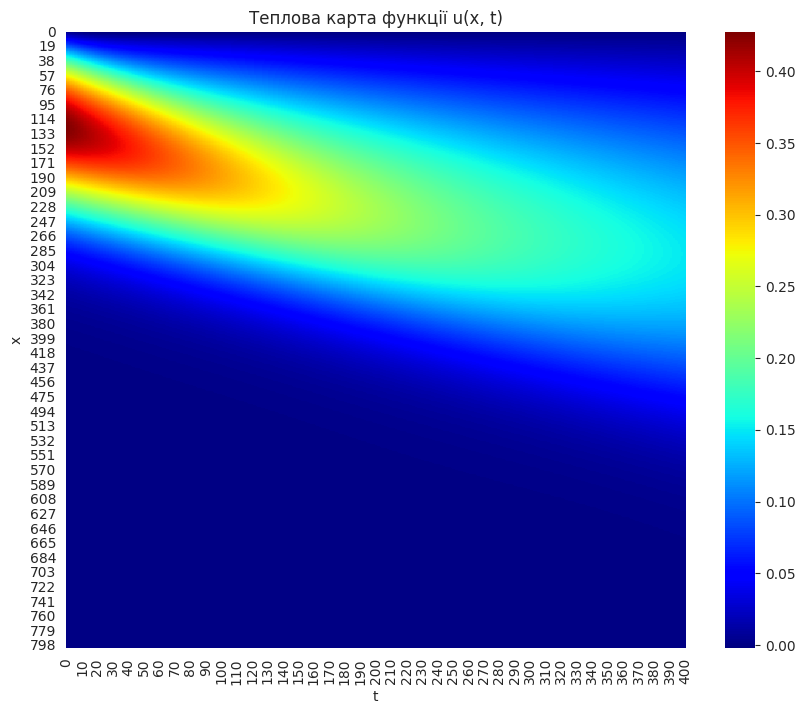

In [ ]:
sns.set_style("white")
plt.figure(figsize=(10,8))
sns.heatmap(y_pred, cmap='jet')
plt.xlabel('t')
plt.ylabel('x')
plt.title('Теплова карта функції u(x, t)')
plt.show()



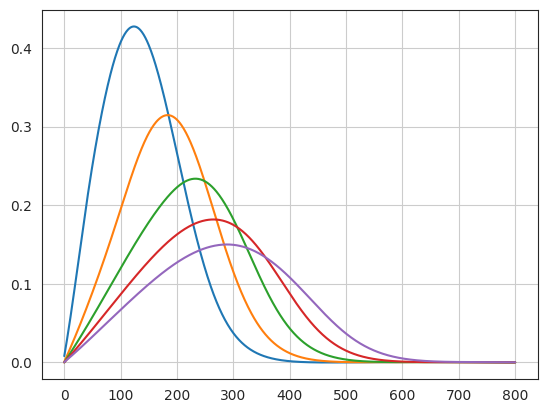

In [ ]:

plt.plot(y_pred[:,0])
plt.plot(y_pred[:,100])
plt.plot(y_pred[:,200])
plt.plot(y_pred[:,300])
plt.plot(y_pred[:,400])

plt.grid(True)
plt.show()

In [ ]:
t[50]

tensor(1.5000)

In [ ]:
x[150]

tensor(1.5000)

Порівняння з іншими результатами

In [ ]:
def relative_error(exact_values, approx_values):
    # Перевірка на відповідність розмірності списків
    if len(exact_values) != len(approx_values):
        raise ValueError("Списки точних і наближених значень повинні мати однакову довжину.")

    # Ініціалізуємо список для збереження відносних похибок
    relative_errors = []

    # Обчислюємо відносну похибку для кожного спостереження
    for exact, approx in zip(exact_values, approx_values):
        if exact != 0:
            # Обчислення відносної похибки
            error = abs((approx - exact) / exact)
        else:
            # Якщо точне значення дорівнює нулю, встановлюємо похибку як нескінченість
            error = float('inf') if approx != 0 else 0.0

        # Додаємо обчислену відносну похибку до списку
        relative_errors.append(error)

    return relative_errors


In [ ]:
import pandas as pd
data15 = {
    'x': [0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0],
    'Exact': [0.15327, 0.26577, 0.30412, 0.26142, 0.17217, 0.08807, 0.03582, 0.01186, 0.00325, 0.00074],
    'PINN': [y_pred[50,50],y_pred[100,50], y_pred[150,50], y_pred[200,50], y_pred[250,50], y_pred[300,50], y_pred[350,50], y_pred[400,50], y_pred[450,50], y_pred[500,50]]
}

df15 = pd.DataFrame(data15)
df15['Relative Error'] = relative_error(df15['Exact'], df15['PINN'])
df15

,x,Exact,PINN,Relative Error
0,0.5,0.15327,0.129144,0.157410
1,1.0,0.26577,0.289449,0.089095
2,1.5,0.30412,0.366402,0.204794
3,2.0,0.26142,0.312652,0.195977
4,2.5,0.17217,0.179304,0.041436
5,3.0,0.08807,0.071312,0.190283
6,3.5,0.03582,0.020925,0.415840
7,4.0,0.01186,0.004749,0.599542
8,4.5,0.00325,0.000625,0.807758
9,5.0,0.00074,-0.000057,1.076409


In [ ]:
import pandas as pd
data30 = {
    'x': [0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0],
    'Exact': [0.06426, 0.11880, 0.15509, 0.16762, 0.15630, 0.12738, 0.09134, 0.05798, 0.03284, 0.01674],
    'PINN': [y_pred[50,200],y_pred[100,200], y_pred[150,200], y_pred[200,200], y_pred[250,200], y_pred[300,200], y_pred[350,200], y_pred[400,200], y_pred[450,200], y_pred[500,200]]
}

df30 = pd.DataFrame(data30)
df30['Relative Error'] = relative_error(df30['Exact'], df30['PINN'])
df30

,x,Exact,PINN,Relative Error
0,0.5,0.06426,0.057731,0.101599
1,1.0,0.11880,0.119671,0.007329
2,1.5,0.15509,0.178295,0.149624
3,2.0,0.16762,0.222648,0.328289
4,2.5,0.15630,0.230097,0.472149
5,3.0,0.12738,0.181984,0.428673
6,3.5,0.09134,0.103948,0.138030
7,4.0,0.05798,0.043120,0.256293
8,4.5,0.03284,0.013810,0.579479
9,5.0,0.01674,0.003493,0.791328


In [ ]:
x[350]

tensor(3.5000)

In [ ]:
import pandas as pd
data45 = {
    'x': [0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0],
    'Exact': [0.03799, 0.07187, 0.09793, 0.11339, 0.11698, 0.10949, 0.09369, 0.07361, 0.05330, 0.03572],
    'PINN': [y_pred[50,350],y_pred[100,350], y_pred[150,350], y_pred[200,350], y_pred[250,350], y_pred[300,350], y_pred[350,350], y_pred[400,350], y_pred[450,350], y_pred[500,350]]
}

df45 = pd.DataFrame(data45)
df45['Relative Error'] = relative_error(df45['Exact'], df45['PINN'])
df45

,x,Exact,PINN,Relative Error
0,0.5,0.03799,0.036930,0.027906
1,1.0,0.07187,0.075575,0.051545
2,1.5,0.09793,0.112406,0.147815
3,2.0,0.11339,0.142938,0.260585
4,2.5,0.11698,0.161389,0.379626
5,3.0,0.10949,0.161825,0.477989
6,3.5,0.09369,0.140959,0.504529
7,4.0,0.07361,0.101450,0.378208
8,4.5,0.05330,0.057222,0.073580
9,5.0,0.03572,0.024889,0.303231
